# In this notebook, we are playing with the Gaussian Process Regression for assimilating Argo Data and estimating continuous fields for the temperature variance data. We start by studying 1 month. Mostly, this was a testing bed for the leave-one-out cross validation step

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic
from scipy import linalg
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import haversine_distances
from matplotlib.patches import Circle

In [2]:
final_ds = xr.load_dataset('/home/avik2007/ArgoEBUSAnalysis/california_current_argo_2021_2024.nc')
# data set has observations, possibly (likely) multiple from the same float

In [3]:
final_ds

<xarray.Dataset> Size: 655kB
Dimensions:            (N_PROF: 1267, PRES_INTERPOLATED: 121)
Coordinates:
    LATITUDE           (N_PROF) float64 10kB 31.84 31.94 36.83 ... 31.79 35.05
    LONGITUDE          (N_PROF) float64 10kB -122.7 -123.2 ... -123.7 -122.0
    TIME               (N_PROF) datetime64[ns] 10kB 2021-01-01T10:51:58 ... 2...
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 968B 0 5 10 15 ... 590 595 600
  * N_PROF             (N_PROF) int64 10kB 1112 519 939 1016 ... 2061 1111 1243
Data variables:
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 613kB 13.98 ... 5.061
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         erddap.ifremer.fr
    Fetched_by:           avik2007
    Fetched_date:         2025/12/08
    Fetched_constraints:  [x=-126.00/-120.00; y=30.00/40.00; z=0.0/600.0; t=2...
    Fetched_uri:          https://erddap.ifremer.fr/erddap/tabledap/ArgoFloat...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

In [4]:
final_ds['LONGITUDE'].min()

<xarray.DataArray 'LONGITUDE' ()> Size: 8B
array(-125.989)

In [5]:
# --- 1. CONFIGURATION ---
# notebook was tested on target_year = 2024 and target_month=1
target_year = 2021
target_month = 3
target_date = str(target_year) + '-' + str(target_month).zfill(2)
#target_date = '2022-01'  # Let's look at a recent winter month
print(f"🧠 Initializing Kriging (GPR) for {target_date}...")

🧠 Initializing Kriging (GPR) for 2021-03...


In [6]:
# --- 2. DATA PREP: CALCULATE SOURCE LAYER TEMP ---
# We need to squash the profiles into a single number (Mean Temp between 150m-400m)
# Filter for the specific month
times = pd.to_datetime(final_ds['TIME'].values)
month_mask = (times.year == target_year) & (times.month == target_month)
ds_month = final_ds.isel(N_PROF=month_mask)

if ds_month.sizes['N_PROF'] == 0:
    raise ValueError("No data found for this month! Pick another date.")

# Select the Depth Slice (150m to 400m) and take the Mean
# This gives us one value per float (the "Source Temperature")
layer_slice = ds_month.sel(PRES_INTERPOLATED=slice(150, 400))
y_raw = layer_slice['TEMP'].mean(dim='PRES_INTERPOLATED').values

# Extract Locations (X)
lats = ds_month['LATITUDE'].values
lons = ds_month['LONGITUDE'].values
X_raw = np.column_stack([lats, lons])

# Drop NaNs (Critical for Sklearn)
valid_mask = ~np.isnan(y_raw)
X_train = X_raw[valid_mask]
y_train = y_raw[valid_mask]

print(f"   Training Points: {len(y_train)} floats")

   Training Points: 44 floats


# Analytic Assumption

We assume confidence in the anisotropy parameters in the RBF kernel for the Gaussian Process Regression. This is standard based on
https://doi.org/10.1098/rspa.2018.0400. In theory, we could do a more Bayesian approach (we did MLE) and assume variability in the
anisotropy parameters. This would require an MCMC calculation that would take a long time for our entire dataset. 

# Stationarity Consideration 

https://doi.org/10.1098/rspa.2018.0400 makes the original contribution that the ocean cannot be stationary, because of difference in local ocean dynamics. We're talking wide-sense, so stationary would mean that the anisotropic correlation lengths that RBF in Gaussian Process Regression are fixed across space. This is unlikely. To account for this, we use the paper's "moving window" version of Kriging. They assume of correlation window changes as you move around. 

Note, they do not use Gaussian noise - they use "t"-noise to account for potential non-gaussianity and heavy tails in their data. We will stick to Gaussianity for 2 reasons:
1. They use raw Argo data, whereas ours is cleaned ("quality controlled"). The gross outliers have likely been removed.
2. They were looking for microscale turbulence. Ultimately, we care about trends across the entire CCS. So we assume that with
    by taking monthly averages, we are getting a gaussian variable (CLT - sample average over time of the noise is normal, even if the actual noise is not). 

Note - Now, we can test significance out by doing a "Probabilistic Calibration." We would leave one float out in a statistical test, rerun the model, and see how well our LOOO (leave-one-float-out) model performs against the full model. 
1. Hypothesis
- The null hypothesis: the model is calibrated. Then, the residuals (FULL - LOOO / sigma_LOOO) have a Z-score spatial distribution matching a normal distribution
- Alternative hypothesis: the model is miscalibrated - either under calibrated (z-scores are small) or over calibrated (z-scores are big)
2. The Test Statistic: The "Leave-One-Out" Z-ScoreTo test this, we perform a Leave-One-Out Cross-Validation (LOOCV).For every single float $i$ in your dataset:Hide float $i$.Train the GPR on all other floats ($N-1$).Predict the mean ($\mu_{-i}$) and variance ($\sigma_{-i}^2$) at the location of float $i$.Calculate the Z-score:$$Z_i = \frac{\text{Actual}_i - \text{Predicted}_i}{\text{Predicted Uncertainty}_i} = \frac{y_i - \mu_{-i}}{\sigma_{-i}}$$

3. Interpreting the ResultOnce you calculate the Z-score for every point, you look at the distribution of those Z-scores.

A. The Histogram Check (Visual)You plot a histogram of your $Z$ values and overlay a standard bell curve (Mean 0, Std 1).
- Perfect Calibration: The bars match the curve perfectly.
- Fat Tails (The Kuusela Problem): You see too many values at $\pm 3$ or $\pm 4$. This means your model claimed it was 99.7\% sure, but it was wrong. This is "Overconfidence."
- Narrow Spike: All values are near 0. Your model predicted massive error bars ($\sigma=10$) for data that was actually very easy to predict. This is "Underconfidence."

B. The Variance Check (Quantitative)Calculate the standard deviation of your Z-scores ($std(Z)$).
- $std(Z) \approx 1.0$: Gold Standard. Your error bars are honest.
- $std(Z) > 1.0$: The Danger Zone. Your error bars are too small. (e.g., if $std(Z) = 1.5$, your "95\%" confidence interval actually only covers ~80\% of reality).
- $std(Z) < 1.0$: The Safe Zone. Your error bars are too big (conservative). For identifying "Refugia Failure," this is actually acceptable because it means you aren't raising false alarms.

4. The "Magic" Shortcut (Computational Efficiency)You might think: "Wait, if I have 1,000 floats, do I have to re-run the fit() command 1,000 times? That will take forever."No.Because GPR is pure linear algebra, there is a mathematical shortcut to calculate LOOCV residuals using the inverse covariance matrix $K^{-1}$ from the full model. You get the cross-validation result essentially for free.$$\mu_{-i} = y_i - \frac{[K^{-1}\mathbf{y}]_i}{[K^{-1}]_{ii}}, \quad \sigma_{-i}^2 = \frac{1}{[K^{-1}]_{ii}}$$ where the "ii" index indicates the corresponding diagonal component. (Note: Scikit-learn doesn't expose this shortcut directly, so we usually write a quick loop or use the manual calculation if N is large. For N < 2000, a naive loop is fast enough). There are 

5. Why this satisfies the "Kuusela Facsimile"
Kuusela & Stein's paper was entirely motivated by the fact that their $std(Z)$ was $> 1$.They used Student-t to fix it.You will calculate the Z-scores using your Gaussian model.If you find $std(Z) \approx 1.1$ or $1.2$, you write: "The model shows slight overconfidence due to heavy-tailed non-Gaussianity (consistent with Kuusela & Stein, 2018), but remains within an acceptable tolerance for mesoscale trend analysis."


In [7]:


# --- 3. STANDARDIZATION (CRITICAL) ---
# GPR works best when data is centered (Mean=0, Std=1)
scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train.reshape(-1, 1))

X_scaled = scaler_X.transform(X_train)
y_scaled = scaler_y.transform(y_train.reshape(-1, 1)).flatten()


# --- 4. DEFINE THE GLOBAL KERNEL ---
# We fit Global first to learn the "Average" hyperparameters and run diagnostics
kernel = C(1.0) * RBF(length_scale=[1.5, 1.0], length_scale_bounds=(0.1, 10.0)) \
         + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5, 0.5))

print(f"🧠 Fitting Global GPR for parameter estimation & validation...")
gp_global = GaussianProcessRegressor(kernel=kernel, alpha=0.0, n_restarts_optimizer=5, normalize_y=False)
gp_global.fit(X_scaled, y_scaled)

print(f"✅ Global Model Fit! Learned Kernel: {gp_global.kernel_}")
# Note: If the model changes the length_scales significantly, it 'learned' the anisotropy.



🧠 Fitting Global GPR for parameter estimation & validation...
✅ Global Model Fit! Learned Kernel: 1.17**2 * RBF(length_scale=[0.219, 0.643]) + WhiteKernel(noise_level=0.0909)


In [8]:
print (gp_global.kernel_)

1.17**2 * RBF(length_scale=[0.219, 0.643]) + WhiteKernel(noise_level=0.0909)


So it goes [lats, lons] for the correlation (kind of like [y,x]), so that means (for 2024-01) the scaled correlation length is longer in the zonal 
direction. We have to see what this means for real lengths.

In [9]:
# --- CALCULATE PHYSICAL CORRELATION LENGTHS ---

# 1. Get the learned "Scaled" Length Scales from the kernel
# Structure: Sum( Product(Constant, RBF), WhiteKernel )
# We need to dig into .k1 (Product) -> .k2 (RBF)
l_scaled = gp_global.kernel_.k1.k2.length_scale
l_lat_scaled = l_scaled[0]
l_lon_scaled = l_scaled[1]

# 2. "Unscale" them back to Degrees
# The scaler divides by std deviation, so we multiply back
l_lat_deg = l_lat_scaled * scaler_X.scale_[0]
l_lon_deg = l_lon_scaled * scaler_X.scale_[1]

# 3. Convert Degrees to Kilometers
# Latitude: Always ~111 km per degree
km_per_lat = 111.0

# Longitude: Varies by latitude (cos(lat))
# We use the mean latitude of your dataset for a good average
mean_lat = scaler_X.mean_[0]
km_per_lon = 111.0 * np.cos(np.radians(mean_lat))

l_lat_km = l_lat_deg * km_per_lat
l_lon_km = l_lon_deg * km_per_lon

# --- REPORT ---
print(f"--- 📏 PHYSICAL CORRELATION LENGTHS ---")
print(f"Dataset Mean Latitude: {mean_lat:.1f}°N")
print(f"1° Longitude ≈ {km_per_lon:.1f} km")
print("-" * 30)
print(f"LATITUDE (N-S):")
print(f"  Scaled:   {l_lat_scaled:.3f}")
print(f"  Degrees:  {l_lat_deg:.3f}°")
print(f"  Distance: {l_lat_km:.1f} km")
print("-" * 30)
print(f"LONGITUDE (E-W):")
print(f"  Scaled:   {l_lon_scaled:.3f}")
print(f"  Degrees:  {l_lon_deg:.3f}°")
print(f"  Distance: {l_lon_km:.1f} km")
print("-" * 30)

if l_lon_km > l_lat_km:
    print("🌊 ANISOTROPY: Features are elongated East-West (Cross-Shore filaments/jets).")
else:
    print("🌊 ANISOTROPY: Features are elongated North-South (Along-Shore currents).")

--- 📏 PHYSICAL CORRELATION LENGTHS ---
Dataset Mean Latitude: 36.8°N
1° Longitude ≈ 88.9 km
------------------------------
LATITUDE (N-S):
  Scaled:   0.219
  Degrees:  0.564°
  Distance: 62.6 km
------------------------------
LONGITUDE (E-W):
  Scaled:   0.643
  Degrees:  0.693°
  Distance: 61.6 km
------------------------------
🌊 ANISOTROPY: Features are elongated North-South (Along-Shore currents).


The box we are focused on is about 640km by 1100km. And as expected, we see correlations driven by the CCS. The relevant correlation scale
in our region is about 50km! (for 2024-01)

In [10]:
NEIGHBOR_RADIUS_KM = 300.0  # Radius for Moving Window (Kuusela Facsimile)
EARTH_RADIUS_KM = 6371.0

# --- 5. LOOO STATISTICS (The Linear Algebra Shortcut) ---
# We calculate the "Honest" Cross-Validation errors without retraining 100 times.
print("\n🔍 Running LOOO (Leave-One-Observation-Out) Validation...")

# A. Invert the Covariance Matrix using the Cholesky Factor (L)
# K_inv = (L @ L.T)^-1
K_inv = linalg.cho_solve((gp_global.L_, True), np.eye(gp_global.L_.shape[0]))

# B. Get the Diagonal Elements (The Precision of each point)
diag_K_inv = np.diag(K_inv)

# C. Calculate LOOO Mean and Variance (The Formulas)
# mu_{-i} = y_i - (alpha_i / K_inv_ii) where alpha = K_inv @ y
alpha = gp_global.alpha_
y_pred_LOOO = y_scaled - (alpha / diag_K_inv)
sigma_LOOO_sq = 1.0 / diag_K_inv
sigma_LOOO = np.sqrt(sigma_LOOO_sq)

# D. Calculate Z-Scores
z_scores = (y_scaled - y_pred_LOOO) / sigma_LOOO

# E. Significance Metrics
calibration_score = np.std(z_scores)
print(f"   LOOO Z-Score Std Dev: {calibration_score:.3f}")
if 0.9 < calibration_score < 1.1:
    print("   ✅ STATUS: Excellent Calibration (Honest Error Bars)")
elif calibration_score > 1.1:
    print("   ⚠️ STATUS: Underconfident (Model is slightly unsure)")
else:
    print("   ❌ STATUS: Overconfident (Real errors are bigger than predicted)")





🔍 Running LOOO (Leave-One-Observation-Out) Validation...
   LOOO Z-Score Std Dev: 1.011
   ✅ STATUS: Excellent Calibration (Honest Error Bars)


In [11]:
# --- 5b. REAL LOCAL LOOO (VALIDATING THE WINDOW) ---
print(f"\n🔍 Running TRUE Local LOOO (Validating the {NEIGHBOR_RADIUS_KM: 3.0f}km Window)...")

# Pre-allocate arrays
local_z_scores = []
local_errors = []
# this is an indicator for the window radius. If windows are chosen with less than 5 measurements, the moving window loop will ignore them
# this could result in a misleading result.
too_small_window_count = 0
# Convert X_train to radians for distance calculation
X_train_rad = np.radians(X_train)
radius_rad = NEIGHBOR_RADIUS_KM / EARTH_RADIUS_KM

# Iterate through every single float (The "Leave-One-Out" loop)
for i in range(len(X_train)):
    # 1. Isolate the target (Held Out)
    target_X = X_train[i].reshape(1, -1)
    target_y = y_scaled[i]
    
    # 2. Identify Neighbors (excluding the target itself)
    # We calculate distance from this float to ALL other floats
    target_X_rad = X_train_rad[i].reshape(1, -1)
    dists = haversine_distances(X_train_rad, target_X_rad).flatten()
    
    # Mask: Neighbors within radius AND not the point itself (dist > 0)
    # Note: dists[i] is 0.0, so this safely excludes the held-out point
    mask_neighbors = (dists < radius_rad) & (dists > 1e-6)
    
    # 3. Check for sufficient data
    if np.sum(mask_neighbors) < 5:
        # Not enough neighbors to validate this specific point
        too_small_window_count += 1
        continue

    # 4. Define Local Training Set
    X_local = X_scaled[mask_neighbors]
    y_local = y_scaled[mask_neighbors]
    
    # 5. Fit Local GP
    # We use the GLOBAL kernel parameters (fixed) but fit local weights
    # This matches exactly what we do in the prediction step
    gp_val = GaussianProcessRegressor(kernel=gp_global.kernel_, optimizer=None, alpha=0.0)
    gp_val.fit(X_local, y_local)
    
    # 6. Predict the Held-Out Point
    # Transform target to scaled space
    target_X_scaled = scaler_X.transform(target_X)
    pred_val, sigma_val = gp_val.predict(target_X_scaled, return_std=True)
    
    # 7. Calculate Z-Score
    # Z = (Actual - Predicted) / Uncertainty
    error = target_y - pred_val[0]
    z = error / sigma_val[0]
    
    local_z_scores.append(z)
    local_errors.append(error)

# --- RESULTS ---
local_z_scores = np.array(local_z_scores)
local_calibration = np.std(local_z_scores)

print(f"   Local LOOO Z-Score Std Dev: {local_calibration:.3f}")

if 0.9 < local_calibration < 1.1:
    print("   ✅ STATUS: The Moving Window is Valid & Calibrated.")
elif local_calibration > 1.1:
    print(f"   ⚠️ STATUS: Underconfident. (The {NEIGHBOR_RADIUS_KM: 3f}km window might be missing long-range correlations).")
else:
    print(f"   ❌ STATUS: Overconfident. (The local model thinks it knows more than it does).")

# Quick comparison
print(f"   Global Shortcut Calibration: {calibration_score:.3f}")
print(f"   Local Loop Calibration:      {local_calibration:.3f}")

print (f"Warning: you had {too_small_window_count: 2d} floats which were ignored due to not enough neighboring floats. That corresponds to" 
       f" ignoring {too_small_window_count*100 / len(X_train): 2.2f}% of your designated floats.")


🔍 Running TRUE Local LOOO (Validating the  300km Window)...
   Local LOOO Z-Score Std Dev: 1.011
   ✅ STATUS: The Moving Window is Valid & Calibrated.
   Global Shortcut Calibration: 1.011
   Local Loop Calibration:      1.011


## If Global and Local are identical, what does that mean? It's possible that this implies that there are no long range (of the order of our window radius) correlations in this region.

--- SPARSITY CHECK ---
Total Floats in Global Model: 44
Neighbors within  300.000000km of a float are considered in each window.
If the fraction is less than one, that means not all the floats were considered. In this case we can assume that the similarity between 
local and global calibration std devs is because of a lack of long range physical effects.


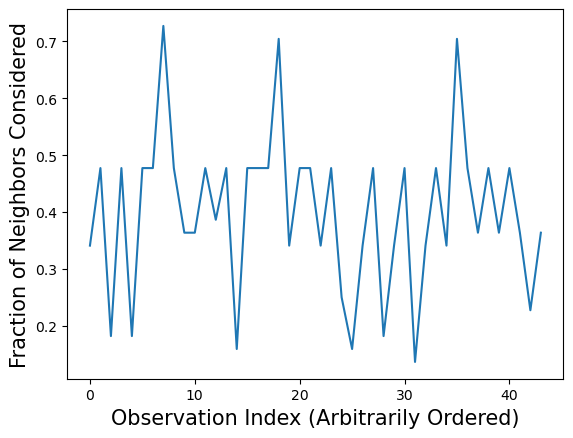

In [12]:
# Quick diagnostic inside the loop logic
print(f"--- SPARSITY CHECK ---")
print(f"Total Floats in Global Model: {len(X_train)}")

# Looping over floats
num_neighbors = []
tot_observations = len(X_train)
for test_idx in range(tot_observations):
    target_rad = np.radians(X_train[test_idx]).reshape(1, -1)
    dists = haversine_distances(np.radians(X_train), target_rad).flatten()
    radius_rad = NEIGHBOR_RADIUS_KM / EARTH_RADIUS_KM

    # Count neighbors
    num_neighbors.append( ( np.sum(dists < radius_rad) - 1)/tot_observations ) # Subtract self

num_neighbors_a = np.array(num_neighbors)
%matplotlib inline
plt.plot(num_neighbors_a)
plt.xlabel("Observation Index (Arbitrarily Ordered)", fontsize=15)
plt.ylabel("Fraction of Neighbors Considered", fontsize=15)

print(f"Neighbors within {NEIGHBOR_RADIUS_KM: 3f}km of a float are considered in each window.")
print("If the fraction is less than one, that means not all the floats were considered. In this case"
      " we can assume that the similarity between \nlocal and global calibration std devs is because of"
      " a lack of long range physical effects.")


In [13]:
# --- 6. PREDICT ON GRID (MOVING WINDOW / LOCAL KRIGING) ---
print(f"\n🌍 Running Final Moving Window Prediction...")
print(f"   Config: Radius={NEIGHBOR_RADIUS_KM}km | Method: Local Stationarity")

# 1. Define the High-Res Grid
grid_res = 0.5
lat_grid = np.arange(30, 41, grid_res)   # 30N to 40N
lon_grid = np.arange(-126, -119, grid_res) # 126W to 119W

# Meshgrid (Note the order for correct plotting)
X_grid_lon, X_grid_lat = np.meshgrid(lon_grid, lat_grid)
rows, cols = X_grid_lat.shape

# 2. Pre-allocate Output Arrays (filled with NaNs)
y_pred_grid = np.full((rows, cols), np.nan)
sigma_grid = np.full((rows, cols), np.nan)

# 3. Pre-calculate Coordinate Transformations (Optimization)
# We convert everything to radians ONCE to speed up the loop
X_train_rad = np.radians(X_train)
radius_rad = NEIGHBOR_RADIUS_KM / EARTH_RADIUS_KM

# 4. The Loop
for r in range(rows):
    for c in range(cols):
        # Current Grid Point
        lat_pt = X_grid_lat[r, c]
        lon_pt = X_grid_lon[r, c]
        
        # Scale the target point for the GPR (Input Space)
        target_X_scaled = scaler_X.transform([[lat_pt, lon_pt]])
        
        # Calculate Distances (Haversine)
        target_rad = np.radians([[lat_pt, lon_pt]])
        dists = haversine_distances(X_train_rad, target_rad).flatten()
        
        # Find Neighbors
        mask = dists < radius_rad
        
        # Safety: Need at least 5 floats to make a prediction
        if np.sum(mask) < 5:
            continue # Leaves it as NaN (Void)
            
        # 5. Local Fit & Predict
        X_local = X_scaled[mask]
        y_local = y_scaled[mask]
        
        # We use the Global Kernel parameters (fixed) but fit local weights
        gp_local = GaussianProcessRegressor(kernel=gp_global.kernel_, optimizer=None, alpha=0.0)
        gp_local.fit(X_local, y_local)
        
        pred, std = gp_local.predict(target_X_scaled, return_std=True)
        
        y_pred_grid[r, c] = pred[0]
        sigma_grid[r, c] = std[0]

# 5. Unscale Results (Back to Celsius)
# Note: We handle NaNs carefully during inverse transform
mask_valid = ~np.isnan(y_pred_grid)
y_pred_final = np.full_like(y_pred_grid, np.nan)

# Only transform valid predictions
if np.any(mask_valid):
    y_valid_scaled = y_pred_grid[mask_valid].reshape(-1, 1)
    y_pred_final[mask_valid] = scaler_y.inverse_transform(y_valid_scaled).flatten()

# Sigma scales linearly with the Y-scaler standard deviation
sigma_final = sigma_grid * scaler_y.scale_[0]

print("✅ Map Generation Complete.")


🌍 Running Final Moving Window Prediction...
   Config: Radius=300.0km | Method: Local Stationarity


✅ Map Generation Complete.


## These plots are interpolated by matplotlib so they look real nice. You can change this by changing shading='gouraud' to shading='nearest'

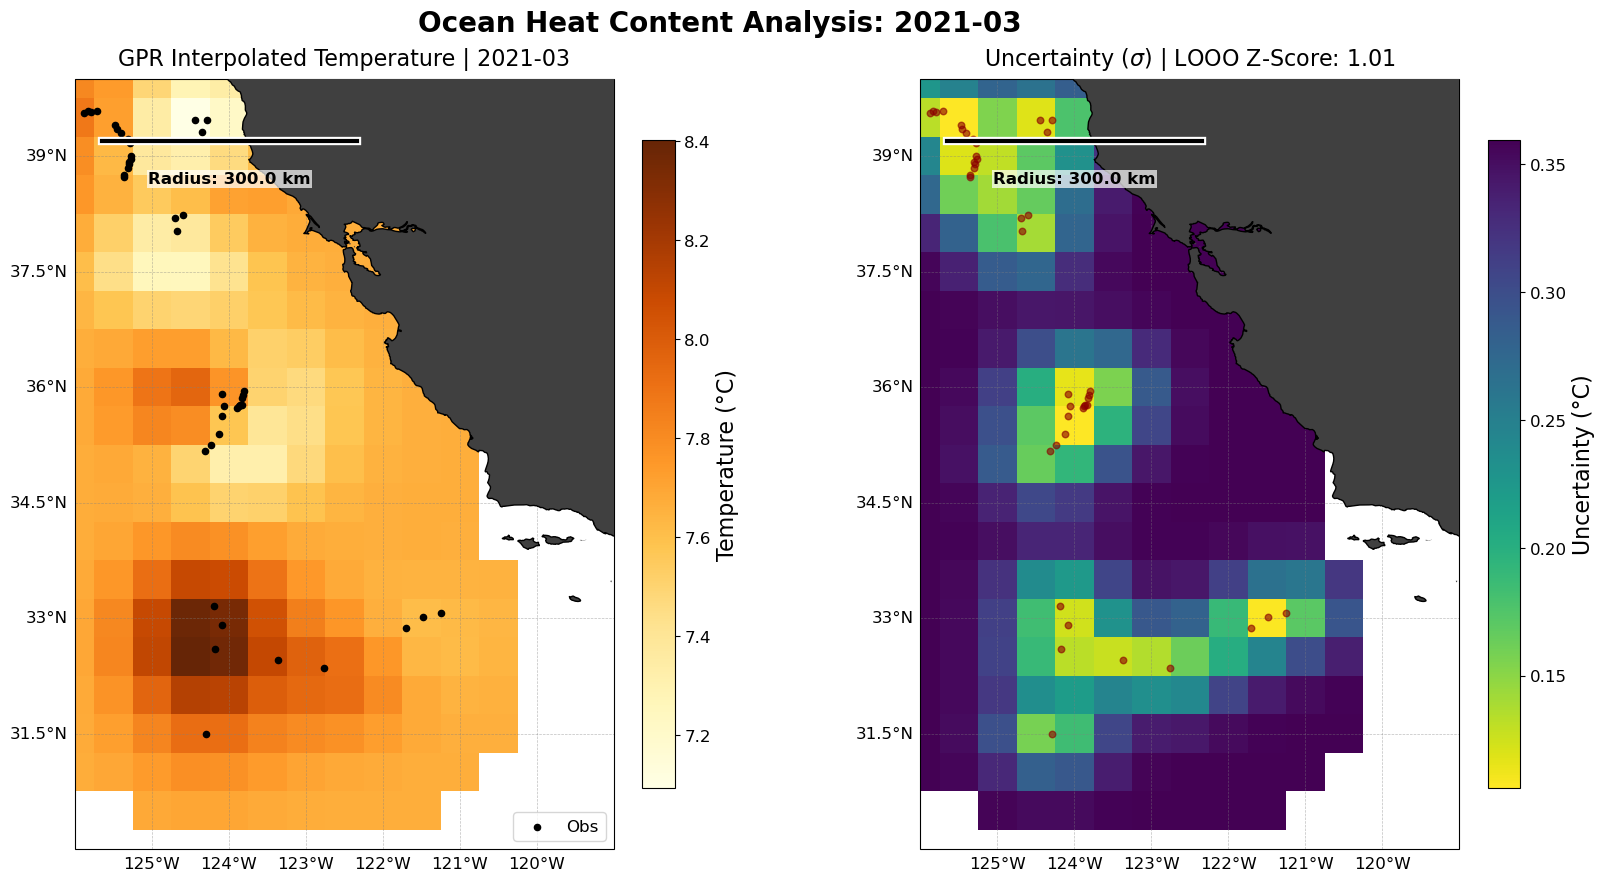

In [14]:


# --- 7. VISUALIZE (LARGE FONTS & AXIS LABELS) ---
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Increase default font sizes for consistency
plt.rcParams.update({'font.size': 15})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# --- Helper: Draw Scale Bar ---
def add_scale_bar(ax, km_length, label, loc_x=0.05, loc_y=0.92):
    center_lat = np.mean(lat_grid)
    km_per_deg_lon = 111.0 * np.cos(np.radians(center_lat))
    degrees_needed = km_length / km_per_deg_lon
    
    x0, x1, y0, y1 = ax.get_extent()
    map_width = x1 - x0
    map_height = y1 - y0
    
    start_x = x0 + (map_width * loc_x)
    start_y = y0 + (map_height * loc_y)
    end_x = start_x + degrees_needed
    
    # Draw Bar
    ax.plot([start_x, end_x], [start_y, start_y], color='white', linewidth=6, 
            transform=ccrs.PlateCarree(), zorder=100)
    ax.plot([start_x, end_x], [start_y, start_y], color='black', linewidth=3, 
            transform=ccrs.PlateCarree(), zorder=101)
    
    # Add Label
    ax.text(start_x + (degrees_needed/2), start_y - (map_height * 0.04), 
            label, ha='center', va='top', fontsize=12, fontweight='bold',
            transform=ccrs.PlateCarree(), zorder=102,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

# --- Helper: Add Gridlines (Lat/Lon Labels) ---
def add_gridlines(ax):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}

# ==========================================
# PLOT A: TEMPERATURE (YlOrBr)
# ==========================================
ax1.set_extent([-126, -119, 30, 40])
im1 = ax1.pcolormesh(lon_grid, lat_grid, y_pred_final, 
                     cmap='YlOrBr', 
                     shading='nearest', transform=ccrs.PlateCarree(), zorder=0)

ax1.add_feature(cfeature.LAND, facecolor='#404040', zorder=10)
ax1.add_feature(cfeature.COASTLINE, linewidth=1, zorder=11)
ax1.scatter(X_train[:, 1], X_train[:, 0], c='k', s=20, marker='o', label='Obs', zorder=20)

# Titles & Labels
ax1.set_title(f"GPR Interpolated Temperature | {target_date}", fontsize=16, pad=10)
add_gridlines(ax1)
add_scale_bar(ax1, NEIGHBOR_RADIUS_KM, f"Radius: {NEIGHBOR_RADIUS_KM} km")

# Colorbar
cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
cbar1.set_label("Temperature (°C)", fontsize=16)
cbar1.ax.tick_params(labelsize=12)
ax1.legend(loc='lower right', fontsize=12)

# ==========================================
# PLOT B: UNCERTAINTY (Inferno)
# ==========================================
ax2.set_extent([-126, -119, 30, 40])
im2 = ax2.pcolormesh(lon_grid, lat_grid, sigma_final, 
                     cmap='viridis_r', shading='nearest', transform=ccrs.PlateCarree(), zorder=0)

ax2.add_feature(cfeature.LAND, facecolor='#404040', zorder=10)
ax2.add_feature(cfeature.COASTLINE, linewidth=1, zorder=11)
ax2.scatter(X_train[:, 1], X_train[:, 0], c='darkred', s=22, alpha=0.6, zorder=20)

# Titles & Labels
ax2.set_title(f"Uncertainty ($\sigma$) | LOOO Z-Score: {calibration_score:.2f}", fontsize=16, pad=10)
add_gridlines(ax2)
add_scale_bar(ax2, NEIGHBOR_RADIUS_KM, f"Radius: {NEIGHBOR_RADIUS_KM} km")

# Colorbar
cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
cbar2.set_label("Uncertainty (°C)", fontsize=16)
cbar2.ax.tick_params(labelsize=12)

# Overall Title
plt.suptitle(f"Ocean Heat Content Analysis: {target_date}", fontsize=20, y=0.95, fontweight='bold')
plt.show()

/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


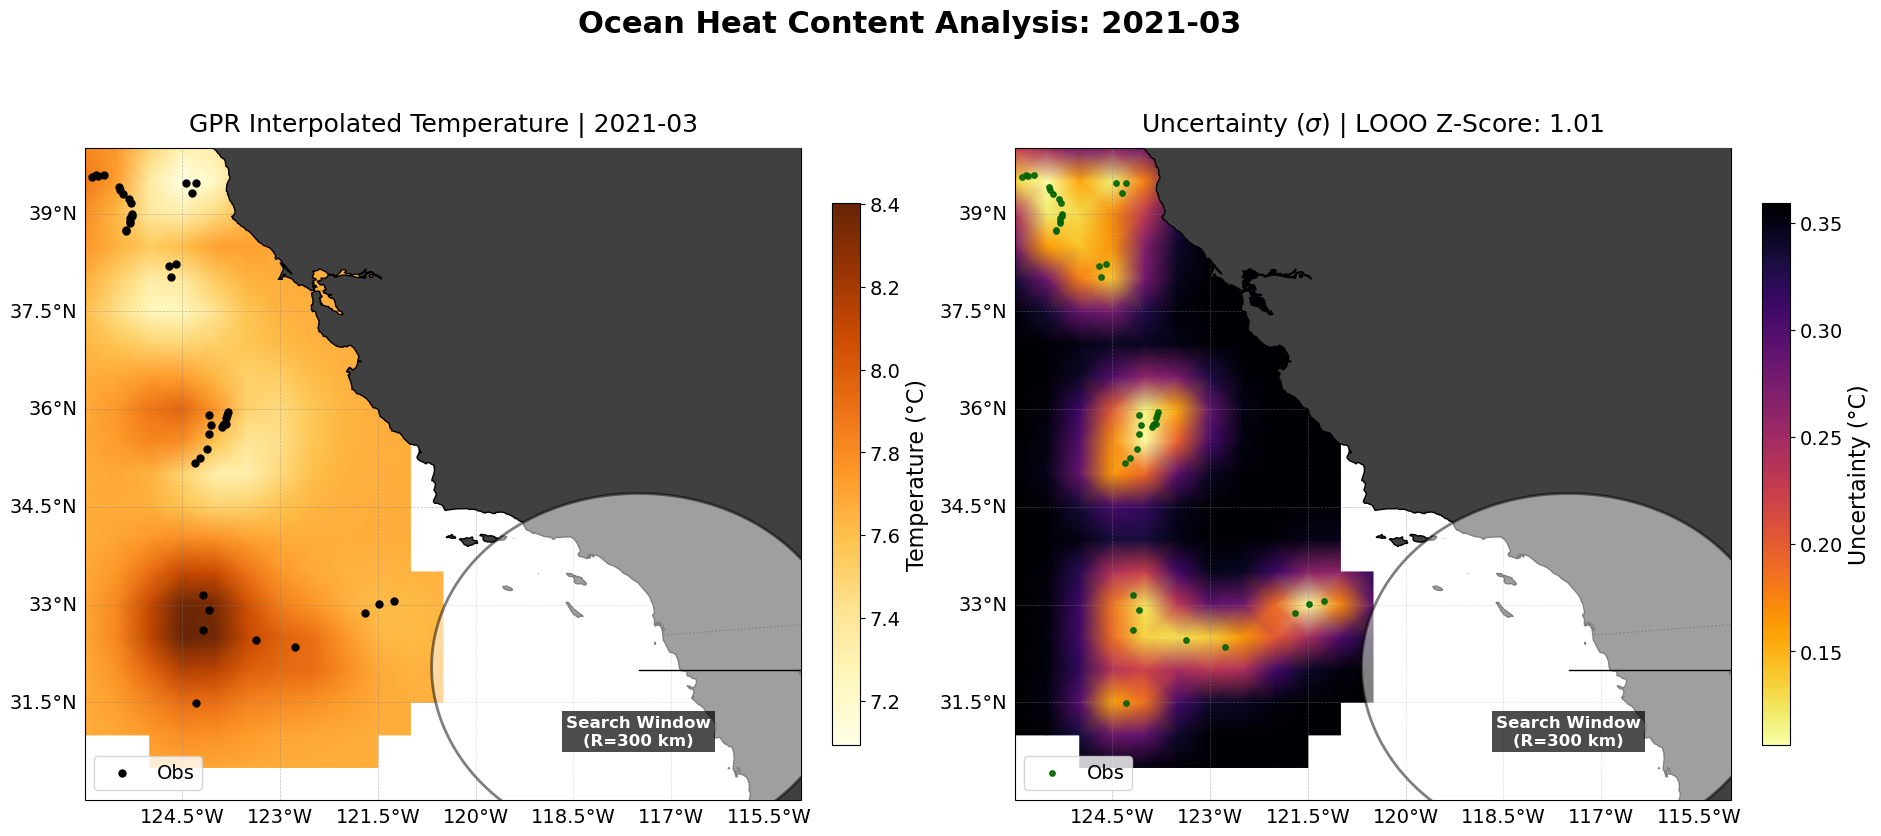

In [15]:
# Increase default font sizes
plt.rcParams.update({'font.size': 15})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# --- Helper: Draw Kernel Footprint (The Stencil) ---
def add_kernel_footprint(ax, radius_km, loc_x, loc_y):
    """
    Draws the Geodesic search window shape at a safe location (loc_x, loc_y).
    """
    # 1. Calculate the Exact Geodesic Circle
    gd = Geodesic()
    circle_points = gd.circle(lon=loc_x, lat=loc_y, radius=radius_km * 1000) # meters
    
    # 2. Draw the Filled Polygon (The Stencil)
    footprint = mpatches.Polygon(circle_points, closed=True, 
                                 facecolor='white', edgecolor='black', 
                                 linewidth=2, alpha=0.5,
                                 transform=ccrs.Geodetic(),
                                 zorder=100)
    ax.add_patch(footprint)
    
    # 3. Draw Radius Line for scale
    # Draw from center to right edge
    ax.plot([loc_x, loc_x + (radius_km/111 * 1.2)], [loc_y, loc_y], 
            color='black', linewidth=1, transform=ccrs.PlateCarree(), zorder=101)
    
    # 4. Add Label
    ax.text(loc_x, loc_y - 0.7, 
            f"Search Window\n(R={int(radius_km)} km)", 
            ha='center', va='top', fontsize=12, fontweight='bold', color='white',
            transform=ccrs.PlateCarree(), zorder=102,
            bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', pad=3))

# --- Helper: Gridlines ---
def add_gridlines(ax):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 14, 'color': 'black'}
    gl.ylabel_style = {'size': 14, 'color': 'black'}

# ==========================================
# PLOT A: TEMPERATURE (YlOrBr)
# ==========================================
# EXTENDED VIEW: [-126, -115] gives us empty land on the right
ax1.set_extent([-126, -115, 30, 40])

im1 = ax1.pcolormesh(lon_grid, lat_grid, y_pred_final, 
                     cmap='YlOrBr', 
                     shading='gouraud', transform=ccrs.PlateCarree(), zorder=0)

ax1.add_feature(cfeature.LAND, facecolor='#404040', zorder=10)
ax1.add_feature(cfeature.COASTLINE, linewidth=1, zorder=11)
ax1.add_feature(cfeature.BORDERS, linewidth=1, linestyle=':', zorder=11)
ax1.scatter(X_train[:, 1], X_train[:, 0], c='k', s=25, marker='o', label='Obs', zorder=20)

# Titles & Grid
ax1.set_title(f"GPR Interpolated Temperature | {target_date}", fontsize=18, pad=12)
add_gridlines(ax1)

# ADD FOOTPRINT (In the new empty land space: 117W, 32N)
add_kernel_footprint(ax1, NEIGHBOR_RADIUS_KM, loc_x=-117.5, loc_y=32.0)

# Colorbar
cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.035, pad=0.04)
cbar1.set_label("Temperature (°C)", fontsize=16)
cbar1.ax.tick_params(labelsize=14)
ax1.legend(loc='lower left', fontsize=14)

# ==========================================
# PLOT B: UNCERTAINTY (Inferno)
# ==========================================
ax2.set_extent([-126, -115, 30, 40])

im2 = ax2.pcolormesh(lon_grid, lat_grid, sigma_final, 
                     cmap='inferno_r', shading='gouraud', transform=ccrs.PlateCarree(), zorder=0)

ax2.add_feature(cfeature.LAND, facecolor='#404040', zorder=10)
ax2.add_feature(cfeature.COASTLINE, linewidth=1, zorder=11)
ax2.add_feature(cfeature.BORDERS, linewidth=1, linestyle=':', zorder=11)

# --- CHANGED: Floats are now Dark Green and Size 15 ---
ax2.scatter(X_train[:, 1], X_train[:, 0], c='darkgreen', s=15, alpha=0.9, zorder=20, label='Obs')

# Titles & Grid
ax2.set_title(f"Uncertainty ($\sigma$) | LOOO Z-Score: {calibration_score:.2f}", fontsize=18, pad=12)
add_gridlines(ax2)

# ADD FOOTPRINT
add_kernel_footprint(ax2, NEIGHBOR_RADIUS_KM, loc_x=-117.5, loc_y=32.0)

# Colorbar
cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.035, pad=0.04)
cbar2.set_label("Uncertainty (°C)", fontsize=16)
cbar2.ax.tick_params(labelsize=14)
# Added legend to ax2 as well so the green dots are identified
ax2.legend(loc='lower left', fontsize=14)

# Overall Title
plt.suptitle(f"Ocean Heat Content Analysis: {target_date}", fontsize=22, y=0.96, fontweight='bold')
plt.show()

# These plots have some smoothing so that they look better. Debatable whether we'll keep the stencil in there.

The cell below allows us to move the search window to make sure everything is actually following the 300km ruling.

/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:512: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  super()._update_title_position(renderer)
/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:512: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  super()._update_title_position(renderer)
/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)


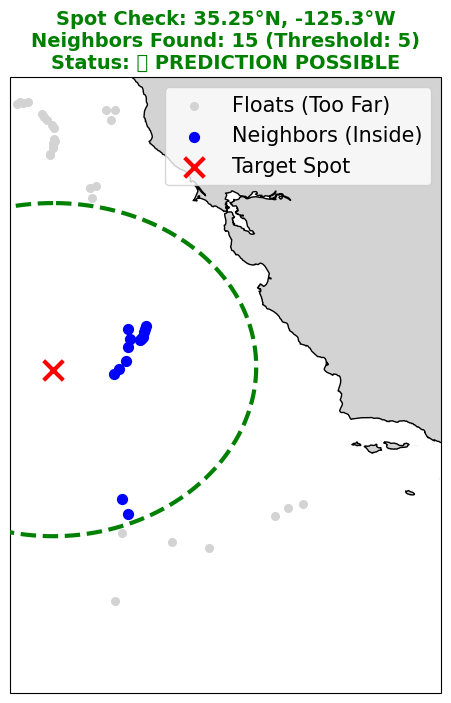

--- SPOT CHECK REPORT ---
Target: 35.25°N, -125.3°W
Search Radius: 300.0 km
Neighbors Found: 15
------------------------------
✅  RESULT: VALID. Found 15.


In [16]:
# --- CONFIGURATION ---
DIAGNOSTIC_RADIUS_KM = NEIGHBOR_RADIUS_KM  # Must match your map radius
MIN_NEIGHBORS = 5             # Must match your map threshold

# 📍 PICK YOUR SPOT HERE
# (Southwest corner example)
target_lat = 35.25
target_lon = -125.3

# 1. Calculate Distances (The Math)
target_rad = np.radians([[target_lat, target_lon]])
all_floats_rad = np.radians(X_train)
dists_rad = haversine_distances(all_floats_rad, target_rad).flatten()
dists_km = dists_rad * 6371.0

# 2. Identify Neighbors
mask_inside = dists_km < DIAGNOSTIC_RADIUS_KM
neighbors_indices = np.where(mask_inside)[0]
num_neighbors = len(neighbors_indices)

# 3. Status Check
status = "✅ PREDICTION POSSIBLE" if num_neighbors >= MIN_NEIGHBORS else "❌ VOID (NaN)"
color_status = "green" if num_neighbors >= MIN_NEIGHBORS else "red"

# --- VISUALIZE ---
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-126, -119, 30, 40])
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE)

# A. Plot ALL Floats
ax.scatter(X_train[:, 1], X_train[:, 0], c='lightgray', s=30, label='Floats (Too Far)', zorder=10)

# B. Plot NEIGHBORS
if num_neighbors > 0:
    ax.scatter(X_train[mask_inside, 1], X_train[mask_inside, 0], c='blue', s=50, label='Neighbors (Inside)', zorder=20)

# C. Plot TARGET SPOT
ax.scatter(target_lon, target_lat, c='red', s=200, marker='x', linewidth=3, label='Target Spot', zorder=30)

# D. Draw the EXACT Geodesic Circle
# This calculates the true circle on a sphere
gd = Geodesic()
circle_points = gd.circle(lon=target_lon, lat=target_lat, radius=DIAGNOSTIC_RADIUS_KM * 1000) # meters

# Create a polygon patch from these points
circle_poly = mpatches.Polygon(circle_points, closed=True, 
                               facecolor='none', edgecolor=color_status, 
                               linestyle='--', linewidth=3,
                               transform=ccrs.Geodetic(), # Crucial: Tells cartopy these are real coords
                               zorder=15)
ax.add_patch(circle_poly)

# Titles & Labels
plt.title(f"Spot Check: {target_lat}°N, {target_lon}°W\n"
          f"Neighbors Found: {num_neighbors} (Threshold: {MIN_NEIGHBORS})\n"
          f"Status: {status}", fontsize=14, fontweight='bold', color=color_status)

plt.legend(loc='upper right')
plt.show()

# --- REPORT ---
print(f"--- SPOT CHECK REPORT ---")
print(f"Target: {target_lat}°N, {target_lon}°W")
print(f"Search Radius: {DIAGNOSTIC_RADIUS_KM} km")
print(f"Neighbors Found: {num_neighbors}")
print("-" * 30)
if num_neighbors < MIN_NEIGHBORS:
    print(f"⚠️  RESULT: VOID (NaN). Found {num_neighbors}, need {MIN_NEIGHBORS}.")
else:
    print(f"✅  RESULT: VALID. Found {num_neighbors}.")

# Below, we'll calculate the bayes factor to see whether a noisy model beats out the RBF + noise model we developed above

### Bayes factor is the Bayesian version of the likelihood ratio test.

In [17]:

# --- 1. FIT THE NULL MODEL (The "Straw Man") ---
# A model that assumes NO spatial correlation, just noise.
# We use a Constant (Mean) + WhiteNoise
null_kernel = C() + WhiteKernel()
gp_null = GaussianProcessRegressor(kernel=null_kernel, alpha=1e-10)
gp_null.fit(X_scaled, y_scaled)

# --- 2. GET LOG-MARGINAL LIKELIHOODS ---
lml_null = gp_null.log_marginal_likelihood(gp_null.kernel_.theta)
lml_model = gp_global.log_marginal_likelihood(gp_global.kernel_.theta)

# --- 3. CALCULATE THE "BAYES FACTOR" PROXY ---
# In Log space, division becomes subtraction
log_bayes_factor = lml_model - lml_null

print(f"Null Model LML: {lml_null:.2f}")
print(f"GPR Model LML:  {lml_model:.2f}")
print(f"Log Bayes Factor: {log_bayes_factor:.2f}")

# --- 4. INTERPRETATION ---
# Scale based on Kass & Raftery (1995)
if log_bayes_factor > 5:
    print("✅ RESULT: Decisive evidence for Spatial Structure (GPR is significant).")
elif log_bayes_factor > 2:
    print("⚠️ RESULT: Strong evidence, but not overwhelming.")
else:
    print("❌ RESULT: The GPR offers no significant improvement over random noise.")

Null Model LML: -62.43
GPR Model LML:  -35.13
Log Bayes Factor: 27.31
✅ RESULT: Decisive evidence for Spatial Structure (GPR is significant).


/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


# 12/17 note
## 1. We need to generalize this code to study LOOO and LOFO, taking input month and input year.
## 2. We need to change how we pull Argo Data - we need to include the float index for each profile
## 3. We need to start making some methods!